To learn more about the dataset and the competition, visit the website: [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic/)

# About this notebook

The **goal of this notebook is to show that a solution that is both simple and effective is possible when proper data preprocessing and exploration is carried out**. Accordingly, the main part of this notebook focuses on the exploratory data analysis, which involves data preprocessing, outlier and missing value handling and feature engineering. 

The models evaluated are **logistic regression and tree-based models** including random forests and gradient boosted decision trees.  

# Exploratory data analysis

Import the necessary libraries and load the data.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
import time

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import data
df_train = pd.read_csv("https://raw.githubusercontent.com/jpconher/Kaggle_Spaceship_Titanic/refs/heads/main/data/train.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/jpconher/Kaggle_Spaceship_Titanic/refs/heads/main/data/test.csv")

# show the first 5 rows of the training data
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


More than 8.500 observations in the training set and 14 columns including the dependent variable $Transported$. The test set is about half the size of the training set.

In [2]:
print("Training set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

Training set shape: (8693, 14)
Test set shape: (4277, 13)


There are both numeric and categorical explanatory variables. Also, we can already see that there are missing values... 😅 

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## Dependent variable

$Transported$ is a boolean type variable. The value $True$ is slightly most common with a relative frequency of 50.4%.

<Axes: ylabel='count'>

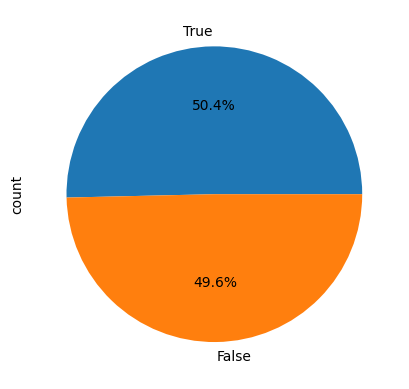

In [4]:
df_train['Transported'].value_counts().plot.pie(autopct='%1.1f%%')

## Independent variables

### Numerical variables

The median person was 27 years old and did not spend anything on amenities.

In [5]:
# Obtain numeric columns
numerical_columns = df_train.select_dtypes(include=['int64', 'float64']).columns

# Compute descriptive statistics
df_train[numerical_columns].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


The numerical variables show low correlation among them.

<Axes: >

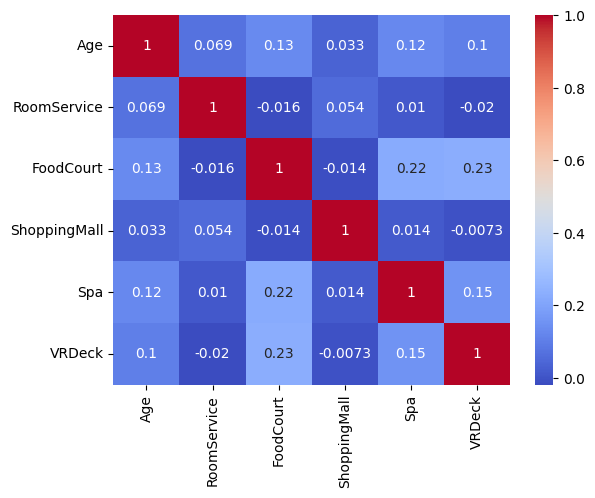

In [6]:
# Plot heatmap
sns.heatmap(df_train[numerical_columns].corr(), annot=True, cmap='coolwarm')

#### Age

Some insights can be extracted from the plot of the distribution of $Age$:
* 0-18 years old more likely to be transported (especially 0-4 years old).
* 18-25 years old less likely to be transported.
* 25-40 years old slightly less likely to be transported.
* Above 40 years old no significant difference.

Possible features:
* Dummies for each age group.
* Alternatively, include higher order terms (at least third order) to model relationship.



Text(0.5, 1.0, 'Distribution of Age')

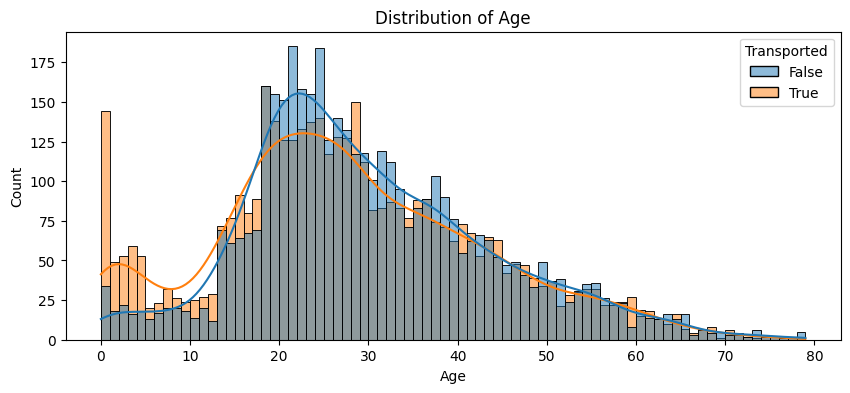

In [7]:
# age
plt.figure(figsize=(10,4))
sns.histplot(data=df_train, x='Age', hue='Transported', binwidth=1, kde=True)
plt.title('Distribution of Age')

#### Expenditure features (amenities)

Regarding expenditure variables, we can make the following observations:
* Those who don't spend any money have higher likelihood of being transported than on average (which is around 50% likelihood). 
* The more the passenger spends on $VRDeck$, $Spa$ and $RoomService$ the lower the likelihood of being transported.
* Given that the passenger spends some money on $ShoppingMall$ or $FoodCourt$, the more they spend, the higher the likelihood of being transported.

For modelling these relationships two things should be considered:
* There seems to be a "jump" in the likelihood between the passenger spending any amount (> 0) and not spending at all (= 0). 
* Provided the passenger has spent on that amenity, the relationship between amount of the expenditure on the amenity and likelihood of being transported seems to be exponential (little effect for small amounts, large effects for larger amounts).

Possible features:
* Sum total expenditures or sum them in two groups depending on whether they contribute to being transported or not.
* Create dummies with expenditure levels for each variable.
* Add a binary indicator for whether the passenger spent some money on the amenity or not. 
* Include higher order terms to capture non-linearity of the relationship. 





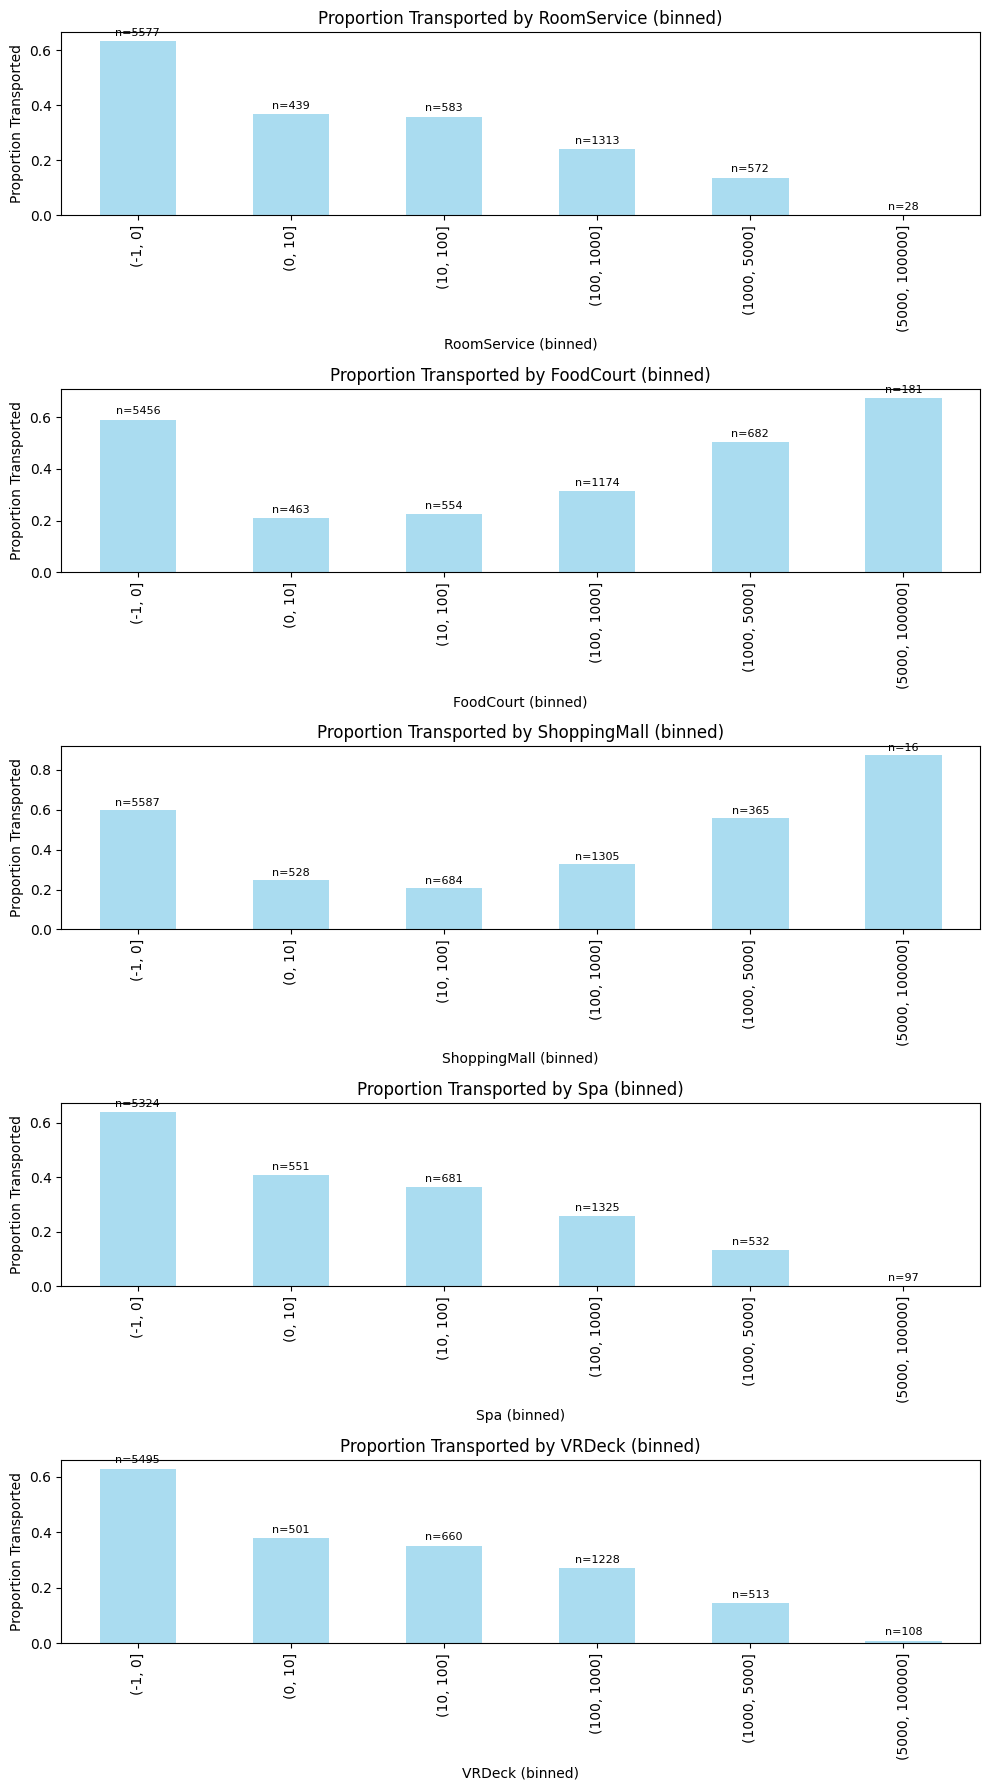

In [8]:
exp_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
interval = [-1, 0, 10, 100, 1000, 5000, 100000]

fig, axes = plt.subplots(len(exp_feats), 1, figsize=(10, 18))

for i, var_name in enumerate(exp_feats):

    # Bin the data
    df_train[var_name + '_bin'] = pd.cut(df_train[var_name], bins=interval)

    # Calculate proportion transported per bin
    prop = df_train.groupby(var_name + '_bin', observed=True)['Transported'].mean()
    count = df_train.groupby(var_name + '_bin', observed=True)['Transported'].count()

    # Plot
    ax = axes[i]
    prop.plot(kind='bar', ax=ax, color='skyblue', alpha=0.7)
    ax.set_title(f'Proportion Transported by {var_name} (binned)')
    ax.set_ylabel('Proportion Transported')
    ax.set_xlabel(var_name + ' (binned)')

    # Optionally, show count as text
    for idx, val in enumerate(prop):
        ax.text(idx, val + 0.02, f'n={count.iloc[idx]}', ha='center', fontsize=8)

    # Drop the temporary bin column
    df_train.drop(columns=[var_name + '_bin'], inplace=True)

plt.tight_layout()

### Categorical variables

* Passangers from planet Earth were less likely to be transported. The opposite was true for passengers from the moon Europa.
* $Cryosleep$ has a considerable discriminatory power. Passengers who do cryosleep are very likely to be transported while passengers who don't are less likely.
* Destination 55 Cancri e is associated with a relatively higher likelihood of being transported. The opposite is true for destination TRAPPIST-1e (although weaker effect).
* VIP passengers have a lower likelihood of being transported (apparently, need to check with a test the significance). For non-VIP passengers almost equal likelihood.

Possible features:
* Convert categorical variables into dummies.
* Need to check two-way relationships to see if interaction dummies can be included in the model. For example, the destination planet may change the likelihood of being transported according to the home planet. 

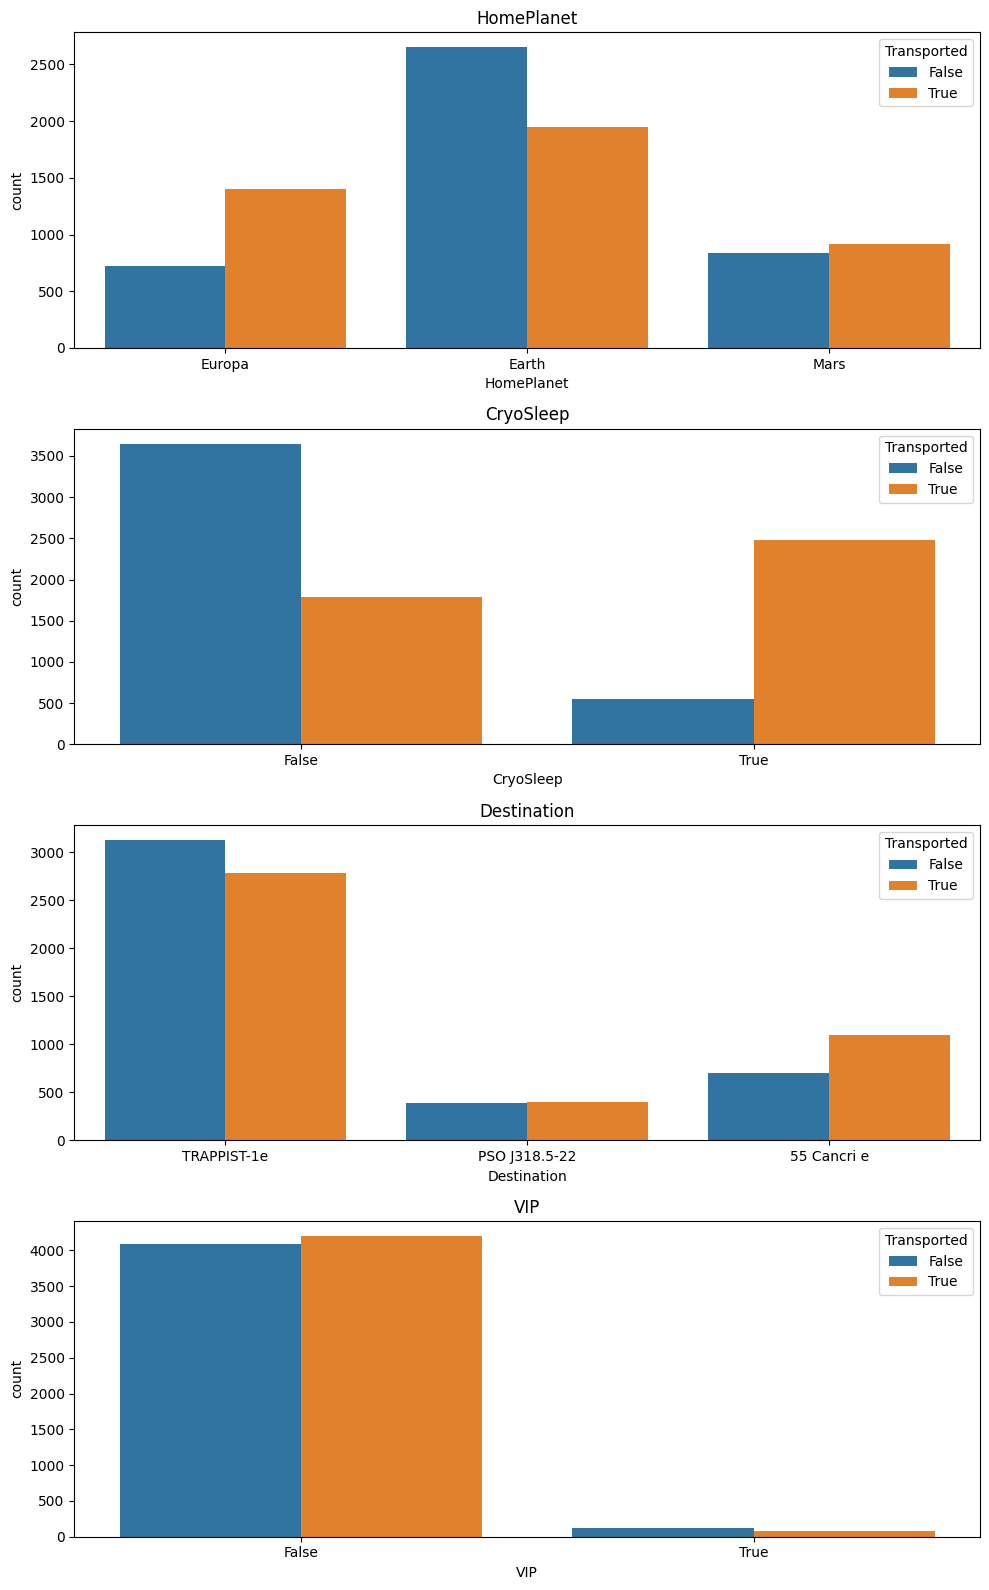

In [9]:
# categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=df_train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)

fig.tight_layout()

Finally, there is a higher probability of being transported for passengers that travel in groups compared to those that travel alone. A good feature could be a dummy variable that indicates whether the passenger is traveling alone or not. 

Text(0.5, 1.0, 'Group Size vs Transported')

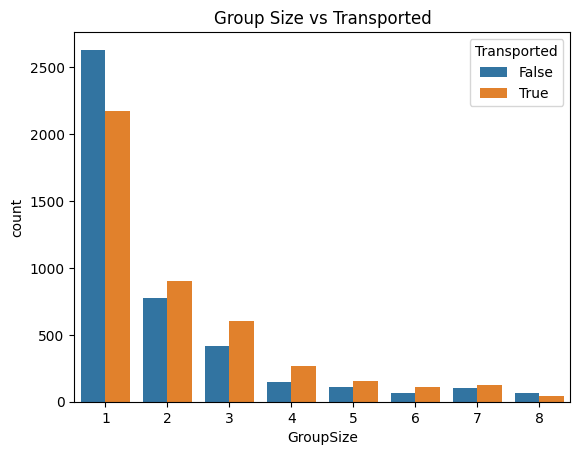

In [10]:
# group of passenger
df_train['Group'] = df_train['PassengerId'].str.split('_', expand = True)[0]

# create GroupSize variable
df_train['GroupSize'] = df_train.groupby('Group')['Group'].transform('count')

# plot
sns.countplot(data=df_train, x='GroupSize', hue='Transported')
plt.title('Group Size vs Transported')

# Data preprocessing

## Missing values

There are missing values in all the features except $Transported$ and $PassengerId$.

In [11]:
df_train.isna().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
Group             0
GroupSize         0
dtype: int64

In general, non-existent relationship of the variable missingness and the likelihood of the passenger being transported.

In [12]:
for col in df_train.columns:
    if col in ['Transported', 'PassengerId']:
        continue
    name = col + "Missing"
    df_train[name] = df_train[col].isna().astype(int)
    print(df_train.groupby(name)['Transported'].agg(['count', 'mean']))
    df_train.drop(name, axis=1, inplace=True)

                   count      mean
HomePlanetMissing                 
0                   8492  0.503415
1                    201  0.512438
                  count      mean
CryoSleepMissing                 
0                  8476  0.504011
1                   217  0.488479
              count      mean
CabinMissing                 
0              8494  0.503650
1               199  0.502513
                    count      mean
DestinationMissing                 
0                    8511  0.503584
1                     182  0.505495
            count      mean
AgeMissing                 
0            8514  0.503641
1             179  0.502793
            count      mean
VIPMissing                 
0            8490  0.503416
1             203  0.512315
                    count      mean
RoomServiceMissing                 
0                    8512  0.504582
1                     181  0.458564
                  count      mean
FoodCourtMissing                 
0                  8510 

When the passenger has more than one feature missing, the likelihood of being transported is slightly (yet significantly) higher. This information will be kept as a possible candidate for our models.

In [13]:
# create dummy describing whether the observation has missing values.
df_train['MultipleMissing'] = (df_train.isna().sum(axis=1) > 1)

print(df_train.groupby(['MultipleMissing'])['Transported'].agg(['count', 'mean']))

                 count      mean
MultipleMissing                 
False             8473  0.502537
True               220  0.545455


### HomePlanet

Groups always come from the same home planet.

In [14]:
# group of passenger
df_train['Group'] = df_train['PassengerId'].str.split('_', expand = True)[0]

# number of groups with more than one home planet
print("There are", sum(df_train.groupby(['Group'])['HomePlanet'].nunique() > 1),
      "groups with more than one home planet.")

# get home planet for each group
x = df_train.groupby('Group')['HomePlanet'].unique()

There are 0 groups with more than one home planet.


Passengers who travel on decks A, B, C and T all come from Europa while passengers who travel on deck G come from the Earth. Moreover, since no VIP passengers come from Earth, passengers who travel on deck F and are VIP must come from Mars. 

In [15]:
# extract deck, num & side
df_train[['Deck', 'Num', 'Side']] = df_train['Cabin'].str.split('/', expand=True)

print(df_train.groupby(['Deck', 'HomePlanet'])['PassengerId'].agg(['count']))
print(df_train.groupby(['VIP', 'HomePlanet'])['PassengerId'].agg(['count']))

                 count
Deck HomePlanet       
A    Europa        252
B    Europa        766
C    Europa        734
D    Europa        186
     Mars          282
E    Earth         395
     Europa        128
     Mars          330
F    Earth        1614
     Mars         1110
G    Earth        2498
T    Europa          4
                  count
VIP   HomePlanet       
False Earth        4487
      Europa       1958
      Mars         1653
True  Europa        131
      Mars           63


All passengers who share the same last name come from the same home planet.

In [16]:
# extract last name
df_train[['GivenName', 'LastName']] = df_train['Name'].str.split(' ', expand=True)

# number of people with duplicate last names
print("There are", sum(df_train.groupby(['LastName'])['PassengerId'].nunique() > 1),
      "last names with more than one person.")

# number of home planets by last name
print("Yet, there are", sum(df_train.groupby(['LastName'])['HomePlanet'].nunique() > 1),
      "last names with more than one home planet.")

# get home planet for each last name
x = df_train.groupby('LastName')['HomePlanet'].unique()

There are 1835 last names with more than one person.
Yet, there are 0 last names with more than one home planet.


The remaining missing values are replaced by the most frequent home planet (Earth).

In [17]:
def solve_missingness_homeplanet(df:pd.DataFrame) -> pd.DataFrame:
    """
    Function to replace missing values in the HomePlanet column.

    Args:
    - df (pd.DataFrame): DataFrame containing the HomePlanet column.
    Returns:
    - df (pd.DataFrame): DataFrame with missing values in HomePlanet replaced.
    """

    # replace missing values for passengers belonging to groups with at least 2 passengers

    # group of passenger
    df['Group'] = df['PassengerId'].str.split('_', expand = True)[0]

    # get home planet for each group
    group_planet = df.groupby('Group')['HomePlanet'].unique()

    for p in range(0, df.shape[0]):
        # check if HomePlanet is missing and if the group has known HomePlanet values
        if pd.isna(df.loc[p, 'HomePlanet']) and [y for y in group_planet[df.iloc[p]['Group']] if not pd.isna(y)]:
            # replace missing value with the HomePlanet of the group
            df.loc[p, 'HomePlanet'] = [y for y in group_planet[df.iloc[p]['Group']] if not pd.isna(y)][0]

    # extract deck, num & side
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    
    # replace missing values according to Deck and VIP status
    df.loc[(df['HomePlanet'].isna()) & (df['Deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'
    df.loc[(df['HomePlanet'].isna()) & (df['Deck'] == 'G'), 'HomePlanet'] = 'Earth'
    df.loc[(df['HomePlanet'].isna()) & (df['Deck'] == 'F') & (df['VIP'] == True), 'HomePlanet'] = 'Mars'

    # replace missing values for passengers whose last name appears is shared by, at least, one more passenger

    # extract last name
    df[['GivenName', 'LastName']] = df['Name'].str.split(' ', expand=True)

    # get home planet for each last name
    LastName_planet = df.groupby('LastName')['HomePlanet'].unique()

    for p in range(0, df.shape[0]):
        # check if HomePlanet is missing, if the last name is not missing and if the last name has known HomePlanet values 
        if pd.isna(df.loc[p, 'HomePlanet']) and not pd.isna(df.loc[p, 'LastName']) and \
        [y for y in LastName_planet[df.iloc[p]['LastName']] if not pd.isna(y)]:
            df.loc[p, 'HomePlanet'] = [y for y in LastName_planet[df.iloc[p]['LastName']] if not pd.isna(y)][0]

    # remaining missing values are replaced by most common HomePlanet (Earth)
    df.loc[df['HomePlanet'].isna(), 'HomePlanet'] = 'Earth'

    return df

df_train = solve_missingness_homeplanet(df_train)

print("There are {} missing values for column HomePlanet".format(df_train['HomePlanet'].isna().sum()))

There are 0 missing values for column HomePlanet


### VIP

There are no passengers coming from planet earth who have VIP status. Moreover, there are no VIP passengers traveling from Mars to 55 Cancri.

In [18]:
print(df_train.groupby(['HomePlanet', 'Destination', 'VIP'])['PassengerId'].agg(['count']))

                                count
HomePlanet Destination   VIP         
Earth      55 Cancri e   False    678
           PSO J318.5-22 False    706
           TRAPPIST-1e   False   3115
Europa     55 Cancri e   False    823
                         True      65
           PSO J318.5-22 False      9
                         True      10
           TRAPPIST-1e   False   1132
                         True      56
Mars       55 Cancri e   False    191
           PSO J318.5-22 False     41
                         True       8
           TRAPPIST-1e   False   1420
                         True      58


There are no more (at least that I was able to identify) relationships to infer missing values of $VIP$. Interestingly, the remaining missing values of $VIP$ have a high predictive power for $Transported$.

In [19]:
def solve_missingness_vip(df:pd.DataFrame) -> pd.DataFrame:
    """
    Function to replace missing values in the VIP column.

    Args:
    - df (pd.DataFrame): DataFrame containing the VIP column.
    Returns:
    - df (pd.DataFrame): DataFrame with missing values in VIP replaced.
    """

    # replace missing values according to HomePlanet and Destination
    df.loc[(df['HomePlanet'] == 'Earth') & (df['VIP'].isna()), 'VIP'] = False
    df.loc[(df['HomePlanet'] == 'Mars') &  (df['Destination'] == '55 Cancri e') & (df['VIP'].isna()), 'VIP'] = False

    # replace remaining missing values by Unknown
    df['VIP'] = df['VIP'].fillna('Unknown')

    return df

df_train = solve_missingness_vip(df_train)

print("There are {} missing values for column VIP".format(df_train['VIP'].isna().sum()))

print(df_train.groupby(['VIP', 'Transported'])['Transported'].agg(['count']))

There are 0 missing values for column VIP
                     count
VIP     Transported       
False   False         4163
        True          4250
True    False          123
        True            76
Unknown False           29
        True            52


### CryoSleep

Passengers that spend money (as it is logical) do not CryoSleep.

In [20]:
# create feature with total expenditure
df_train['TotalExpenditure'] = df_train[exp_feats].sum(axis = 1)

n = df_train.loc[(df_train['TotalExpenditure'] > 0) & (df_train['CryoSleep'] == True)].shape[0]
print('There are', n, 'observations with total expenditure > 0 and CryoSleep == True')

There are 0 observations with total expenditure > 0 and CryoSleep == True


Most VIP passengers do not cryosleep (~90% likelihood in our sample).

In [21]:
print(df_train.groupby(['VIP', 'CryoSleep'])['PassengerId'].agg('count'))

VIP      CryoSleep
False    False        5219
         True         2981
True     False         175
         True           21
Unknown  False          45
         True           35
Name: PassengerId, dtype: int64


Most passengers that do not spend any money do not cryosleep (> 80% likelihood).

In [22]:
print(df_train.loc[(df_train['TotalExpenditure'] == 0)].groupby('CryoSleep')['CryoSleep'].agg('count'))

CryoSleep
False     518
True     3037
Name: CryoSleep, dtype: int64


In [23]:
def solve_missingness_CryoSleep(df:pd.DataFrame) -> pd.DataFrame:
    """
    Function to replace missing values in the CryoSleep column.

    Args:
    - df (pd.DataFrame): DataFrame containing the CryoSleep column.
    Returns:
    - df (pd.DataFrame): DataFrame with missing values in CryoSleep replaced.
    """

    # replace missing values according to TotalExpenditure

    # create feature with total expenditure
    df['TotalExpenditure'] = df[exp_feats].sum(axis = 1)

    # replace missing values with False if total expenditure is greater than 0
    df.loc[(df['TotalExpenditure'] > 0) & (df['CryoSleep'].isna()), 'CryoSleep'] = False

    # replace missing values based on VIP status
    df.loc[(df['VIP'] == True) & (df['CryoSleep'].isna()), 'CryoSleep'] = False

    # replace missing values based on total expenditure
    df.loc[(df['TotalExpenditure'] == 0) & (df['CryoSleep'].isna()), 'CryoSleep'] = True

    # replace any remaining missing values (if there are) with most common value (False)
    df['CryoSleep'] = df['CryoSleep'].fillna(False)

    return df

df_train = solve_missingness_CryoSleep(df_train)

print("There are {} missing values for column CryoSleep".format(df_train['CryoSleep'].isna().sum()))

There are 0 missing values for column CryoSleep


### Destination

No clear relations were found to extrapolate missing values. Missing values will form a new category.

In [24]:
def solve_missingness_Destination(df:pd.DataFrame) -> pd.DataFrame:
    """
    Function to replace missing values in the Destination column.

    Args:
    - df (pd.DataFrame): DataFrame containing the Destination column.
    Returns:
    - df (pd.DataFrame): DataFrame with missing values in Destination replaced.
    """

    # replace missing values with label 'Unknown'
    df['Destination'] = df['Destination'].fillna('Unknown')

    return df

df_train = solve_missingness_Destination(df_train)

print("There are {} missing values for column Destination".format(df_train['Destination'].isna().sum()))

There are 0 missing values for column Destination


### Side & Deck (Cabin)

For passengers who travel in groups, missing ship side can be filled by the side of the group since groups always travel in the same side of the ship.

In [25]:
# number of (Cabin) Sides by Group
print("There are", sum(df_train.groupby(['Group'])['Side'].nunique() > 1),
      "groups with more than one ship side.")

There are 0 groups with more than one ship side.


No more relationships have been found. The remaining missing values will make a new category 'Unknown'. 

In [26]:
def solve_missingness_Side(df:pd.DataFrame) -> pd.DataFrame:
    """
    Function to replace missing values in the Side column.

    Args:
    - df (pd.DataFrame): DataFrame containing the Side column.
    Returns:
    - df (pd.DataFrame): DataFrame with missing values in Side replaced.
    """

    # replace missing values according to the passenger's group deck
    side_mode = df.groupby('Group')['Side'].transform(lambda x: statistics.mode(x))
    
    df['Side'] = df['Side'].fillna(side_mode)

    # replace remaining missing values by "Unkown"
    df['Side'] = df['Side'].fillna('Unknown')

    return df

df_train = solve_missingness_Side(df_train)

print("There are {} missing values for column Side".format(df_train['Side'].isna().sum()))


There are 0 missing values for column Side


No relationships found for $Deck$, missing values will be replaced by 'Unknown'. 

In [27]:
def solve_missingness_Deck(df:pd.DataFrame) -> pd.DataFrame:
    """
    Function to replace missing values in the Deck column.

    Args:
    - df (pd.DataFrame): DataFrame containing the Deck column.
    Returns:
    - df (pd.DataFrame): DataFrame with missing values in Deck replaced.
    """

    # replace missing values by "Unkown"
    df['Deck'] = df['Deck'].fillna('Unknown')

    return df

df_train = solve_missingness_Deck(df_train)

print("There are {} missing values for column Deck".format(df_train['Deck'].isna().sum()))

There are 0 missing values for column Deck


### Age

There are variations in the median age depending on the values of $HomePlanet$, $Destination$, $VIP$ and $CryoSleep$. That information will be used to extrapolate $Age$'s missing values.

In [28]:
df_train.groupby(['HomePlanet', 'Destination', 'VIP', 'CryoSleep'])['Age'].median()

HomePlanet  Destination    VIP      CryoSleep
Earth       55 Cancri e    False    False        23.0
                                    True         18.0
            PSO J318.5-22  False    False        25.0
                                    True         22.0
            TRAPPIST-1e    False    False        24.0
                                    True         21.0
            Unknown        False    False        23.0
                                    True         21.5
Europa      55 Cancri e    False    False        34.0
                                    True         30.0
                           True     False        36.0
                                    True         31.5
                           Unknown  False        31.5
                                    True         34.0
            PSO J318.5-22  False    True         32.0
                           True     False        35.0
            TRAPPIST-1e    False    False        33.0
                                    

In [29]:
def solve_missingness_Age(df:pd.DataFrame) -> pd.DataFrame:
    """
    Function to replace missing values in the Age column.

    Args:
    - df (pd.DataFrame): DataFrame containing the Age column.
    Returns:
    - df (pd.DataFrame): DataFrame with missing values in Age replaced.
    """

    # obtain median age grouping by HomePlanet, Destination, VIP, CryoSleep
    median_age = df.groupby(['HomePlanet', 'Destination', 'VIP', 'CryoSleep'])['Age'].transform('median')

    # fill missing values
    df['Age'] = df['Age'].fillna(median_age)

    return df

df_train = solve_missingness_Age(df_train)

print("There are {} missing values for column Age".format(df_train['Age'].isna().sum()))

There are 0 missing values for column Age


### Expenditure variables (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)

Kids up to 12 years old do not expend any amount of money. Thus, whenever Age <= 12, missing values in any of the expenditure variables can be replaced by 0.

Text(0.5, 1.0, 'Average expenditure by Age')

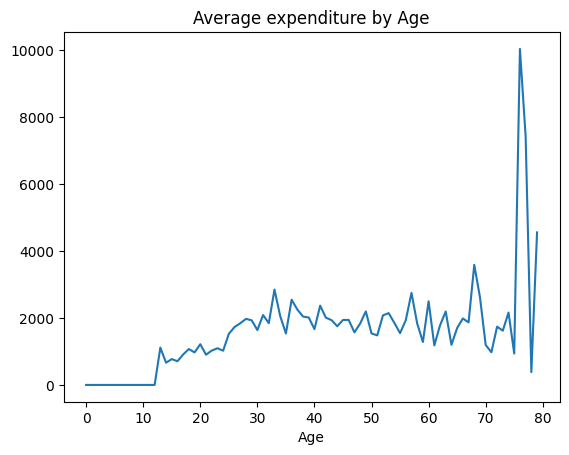

In [30]:
# create TotalExpenditure as the sum of the expenditure in each expenditure variable
df_train['TotalExpenditure'] = df_train[exp_feats].sum(axis = 1)

x = df_train.groupby('Age')['TotalExpenditure'].agg('mean').plot()
x.set_title("Average expenditure by Age")

A passenger who cryosleeps during the travel does not spend any money (as expected) on any of the expenditure features.

In [31]:
df_train.groupby('CryoSleep')['TotalExpenditure'].agg('mean')

CryoSleep
False    2253.589601
True        0.000000
Name: TotalExpenditure, dtype: float64

The remaining missing values are replaced by the median value according to the passenger's values for HomePlanet, Destination and VIP.

In [32]:
def solve_missingness_expenditure_variables(df:pd.DataFrame) -> pd.DataFrame:
    """
    Function to replace missing values in the expenditure columns (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck).

    Args:
    - df (pd.DataFrame): DataFrame containing the expenditure columns.
    Returns:
    - df (pd.DataFrame): DataFrame with missing values in expenditure columns replaced.
    """

    # replace missing values for passengers aged <= 12 by 0
    df.loc[(df['Age'] <= 12), exp_feats] = 0

    # replace missing values for passengers with CryoSleep == True by 0
    df.loc[df['CryoSleep'] == True, exp_feats] = 0

    # replace missing values according to HomePlanet, Destination, VIP and Age
    mask = (df['Age'] > 12) & (df['CryoSleep'] == False)
    median = df.loc[mask].groupby(['HomePlanet', 'Destination', 'VIP'])[exp_feats].transform('median')
    df.loc[mask, exp_feats] = df.loc[mask, exp_feats].fillna(median)

    # any remaining missing value is replaced by 0
    df[exp_feats] = df[exp_feats].fillna(0)

    return df

df_train = solve_missingness_expenditure_variables(df_train)

print("There are the following missing values for expenditure variables:\n")
print(df_train[exp_feats].isna().sum().sort_values(ascending=False))

There are the following missing values for expenditure variables:

RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


## Feature engineering

The following variables will be created:

| Variable | Source | Comment |
| -------- | ------- | ------- |
| $SoleTraveller$  | $PassengerId$    | Indicates whether the passenger is travelling alone or not |
| $Age4$, $Age18$, $Age25$, $Age40$, $AgeOld$ | $Age$ | Each dummy represents an interval (0-4 years old, 5-18 years old...) |
| $AgeSq$, $AgeCu$ | $Age$ | Higher order terms |
| $ExpenditureDummy$ | $RoomService$, $Spa$, $VRDeck$, $FoodCourt$, $ShoppingMall$ | Dummy indicating whether the passenger spent money on at least one amenity |
| $RoomServiceSq$, $RoomServiceCu$ | $RoomService$ | Higher order terms |
| $SpaSq$, $SpaCu$ | $Spa$ | Higher order terms |
| $VRDeckSq$, $VRDeckCu$ | $VRDeck$ | Higher order terms |
| $FoodCourtSq$, $FoodCourtCu$ | $FoodCourt$ | Higher order terms |
| $ShoppingMallSq$, $ShoppingMallCu$ | $ShoppingMall$ | Higher order terms |
| $Deck$ | $Cabin$ | Indicates the Deck the cabin is located |
| $Side$ | $Cabin$ | Indicates the Side the cabin is located |
| $MultipleMissing$ | | Indicates whether more than one variable is missing for the passenger |

Additionally, these variables will be deleted due to their lack of explanatory power / impossibility of inclusion / redundancy:

| Variable |
| -------- |
| $PassengerId$ |
| $Cabin$ |
| $Name$ |
| $Num$ |
| $GivenName$ |
| $LastName$ |
| $Group$ |

Finally, the following categorical variables will be encoded using one-hot encoding:

| Variable |
| -------- |
| $HomePlanet$ |
| $CryoSleep$ |
| $Destination$ |
| $VIP$ |
| $Deck$ |
| $Side$ |

In [33]:
def create_features(df:pd.DataFrame) -> pd.DataFrame:
    """
    Function to create new features.

    Args:
    - df (pd.DataFrame): DataFrame containing all the "source" columns.

    Returns:
    - df (pd.DataFrame): DataFrame containing all the original columns + new features.
    """

    # GroupSize
    df['Group'] = df['PassengerId'].str.split('_', expand = True)[0]
    df['GroupSize'] = df.groupby('Group')['Group'].transform('count')
    df['SoleTraveller'] = (df['GroupSize'] == 1).astype(int)
    df.drop('GroupSize', axis=1, inplace=True)

    # Age4, Age18, Age25, Age40, AgeOld
    df['Age4'] = (df['Age'] <= 4).astype(int)
    df['Age18'] = ((df['Age'] > 4) & (df['Age'] <= 18)).astype(int)
    df['Age25'] = ((df['Age'] > 18) & (df['Age'] <= 25)).astype(int)
    df['Age40'] = ((df['Age'] > 25) & (df['Age'] <= 40)).astype(int)
    df['AgeOld'] = (df['Age'] > 40).astype(int)

    # AgeSq, AgeCu
    df['AgeSq'] = df['Age'] ** 2
    df['AgeCu'] = df['Age'] ** 3
    
    # RoomServiceDummy, FoodCourtDummy, ShoppingMallDummy, SpaDummy, VRDeckDummy
    df['ExpenditureDummy'] = df[exp_feats].sum(axis = 1) > 0
    
    # RoomServiceSq, RoomServiceCu
    df['RoomServiceSq'] = df['RoomService'] ** 2
    df['RoomServiceCu'] = df['RoomService'] ** 3

    # FoodCourtSq, FoodCourtCu
    df['FoodCourtSq'] = df['FoodCourt'] ** 2
    df['FoodCourtCu'] = df['FoodCourt'] ** 3

    # ShoppingMallSq, ShoppingMallCu
    df['ShoppingMallSq'] = df['ShoppingMall'] ** 2
    df['ShoppingMallCu'] = df['ShoppingMall'] ** 3

    # SpaSq, SpaCu 
    df['SpaSq'] = df['Spa'] ** 2
    df['SpaCu'] = df['Spa'] ** 3

    # VRDeckSq, VRDeckCu
    df['VRDeckSq'] = df['VRDeck'] ** 2
    df['VRDeckCu'] = df['VRDeck'] ** 3

    # Deck, Side
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)

    # MultipleMissing
    df['MultipleMissing'] = (df.isna().sum(axis=1) > 1).astype(int)

    return df

def delete_Variables(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to delete variables that are not needed for the model.

    Args:
    - df (pd.DataFrame): DataFrame containing columns to delete.

    Returns:
    - df (pd.DataFrame): DataFrame with the variables deleted.
    """

    cols_to_drop = [
        'Name', 'Cabin', 'Num', 'LastName', 'GivenName', 'Group', 'TotalExpenditure'
    ]
    return df.drop(columns=cols_to_drop, errors='ignore')

def encode_categorical(df:pd.DataFrame, categorical:list) -> pd.DataFrame:
    """
    Function to encode categorical variables. Also, 
    drop redundant variables to avoid perfect multicollinearity.

    Args:
    - df (pd.DataFrame): DataFrame containing categorical variables.
    - categorical (list): List of categorical variable names to encode.
    
    Returns:
    - df (pd.DataFrame): DataFrame with categorical variables encoded.
    """
    
    for col in categorical:
        if col in df.columns:
            # Create dummy variables for each categorical variable
            dummies = pd.get_dummies(df[col], prefix=col)
            # Concatenate the dummies to the original DataFrame
            df = pd.concat([df, dummies], axis=1)

    
    drop = ['HomePlanet', 'HomePlanet_Earth',
        'CryoSleep','CryoSleep_False',
        'Destination', 'Destination_Unknown',
        'VIP', 'VIP_Unknown',
        'Deck', 'Deck_A',
        'Side', 'Side_P',
        'AgeOld']
    
    df.drop(columns=drop, inplace=True)
    
    return df
    
df_train = create_features(df_train)
df_train = delete_Variables(df_train)
cat_feats = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
df_train = encode_categorical(df_train, cat_feats)

# Modelling

Four models will be considered:
1. Logistic regression.
2. Decision tree.
3. Random forest.
4. Gradient boosting decision tree.

Let's start by dividing the training set into a new training set that will be used for obtaining the best hyperparameters for each model and a validation set that will be used to compare the performance among the optimal models.

In [34]:
df_train_train, df_train_valid = train_test_split(df_train, test_size=0.2, train_size=0.8, random_state=11)

Notice that feature selection will not be necessary as we will consider models with regularisation factors and, also, decision trees implicitly perform feature selection. Finally, for logistic regression, we will consider two sets of features one including the $Age$ feature discretised and the other including the continuous $Age$ (together with the second and third order terms). For decision trees only the latter will be considered. 

In [35]:
# extract features and target variable (train set)
X_train = df_train_train.drop(columns=['PassengerId', 'Transported', 'Age4', 'Age18', 'Age25', 'Age40'])
X_train_logistic =  df_train_train.drop(columns=['PassengerId', 'Transported', 'Age', 'AgeSq', 'AgeCu'])
y_train = df_train_train['Transported']

# extract features and target variable (validation set)
X_valid = df_train_valid.drop(columns=['PassengerId', 'Transported', 'Age4', 'Age18', 'Age25', 'Age40'])
X_valid_logistic =  df_train_valid.drop(columns=['PassengerId', 'Transported', 'Age', 'AgeSq', 'AgeCu'])
y_valid = df_train_valid['Transported']

## Hyperparameter optimisation

### Logistic regression

In [36]:
def hyper_opt_logistic(X_train, y_train):
    start = time.time_ns()

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression(max_iter=20000, solver='saga', random_state=11))
    ])

    param_grid = [
        {'logistic__penalty': [None]},  # C value is arbitrary here
        {'logistic__penalty': ['l1', 'l2'], 'logistic__C': [10**(-5), 10**(-2), 1, 5, 10, 20]}
    ]

    grid_log = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0,
        cv=5,
        return_train_score=False
    )

    grid_log.fit(X_train, y_train)

    print("Grid search completed in", (time.time_ns() - start) / (1e9 * 60), "minutes")

    results = pd.DataFrame({
        'params': grid_log.cv_results_['params'],
        'mean_test_score': grid_log.cv_results_['mean_test_score']
    })
    results = results.sort_values(by='mean_test_score', ascending=False)
    print(results)

    return grid_log

Using discretised $Age$ does not lead to better performance. 

In [37]:
print("\nHyperparameter optimization for logistic regression using continuous Age: \n")

grid_log = hyper_opt_logistic(X_train, y_train)

print("\nHyperparameter optimization for logistic regression using discretised Age: \n")

grid_log_discret = hyper_opt_logistic(X_train_logistic, y_train)


Hyperparameter optimization for logistic regression using continuous Age: 

Grid search completed in 3.838473035533333 minutes
                                               params  mean_test_score
6       {'logistic__C': 1, 'logistic__penalty': 'l2'}         0.791198
5       {'logistic__C': 1, 'logistic__penalty': 'l1'}         0.790911
7       {'logistic__C': 5, 'logistic__penalty': 'l1'}         0.789473
8       {'logistic__C': 5, 'logistic__penalty': 'l2'}         0.789329
9      {'logistic__C': 10, 'logistic__penalty': 'l1'}         0.789329
10     {'logistic__C': 10, 'logistic__penalty': 'l2'}         0.789185
11     {'logistic__C': 20, 'logistic__penalty': 'l1'}         0.789185
0                         {'logistic__penalty': None}         0.789042
12     {'logistic__C': 20, 'logistic__penalty': 'l2'}         0.788898
4    {'logistic__C': 0.01, 'logistic__penalty': 'l2'}         0.784869
3    {'logistic__C': 0.01, 'logistic__penalty': 'l1'}         0.776097
2   {'logistic__C': 

### Decision tree

In [38]:
start = time.time_ns()

Decision_Tree = DecisionTreeClassifier(random_state=11)

param_grid = {
    'min_samples_split': [2, 5, 10, 20, 50, 100, 200, 500],
    'ccp_alpha': [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
}

grid_tree = GridSearchCV(
    estimator=Decision_Tree,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0,
    cv=5,
    return_train_score=False
)

grid_tree.fit(X_train, y_train)

print("Grid search completed in", (time.time_ns() - start) / (1e9 * 60), "minutes")

results = pd.DataFrame({
    'params': grid_tree.cv_results_['params'],
    'mean_test_score': grid_tree.cv_results_['mean_test_score']
})
results = results.sort_values(by='mean_test_score', ascending=False)
print(results)

Grid search completed in 0.14518294116666666 minutes
                                             params  mean_test_score
16    {'ccp_alpha': 0.0005, 'min_samples_split': 2}         0.781708
18   {'ccp_alpha': 0.0005, 'min_samples_split': 10}         0.781708
17    {'ccp_alpha': 0.0005, 'min_samples_split': 5}         0.781564
21  {'ccp_alpha': 0.0005, 'min_samples_split': 100}         0.781276
14  {'ccp_alpha': 0.0001, 'min_samples_split': 200}         0.780845
..                                              ...              ...
67      {'ccp_alpha': 0.5, 'min_samples_split': 20}         0.502588
68      {'ccp_alpha': 0.5, 'min_samples_split': 50}         0.502588
69     {'ccp_alpha': 0.5, 'min_samples_split': 100}         0.502588
70     {'ccp_alpha': 0.5, 'min_samples_split': 200}         0.502588
71     {'ccp_alpha': 0.5, 'min_samples_split': 500}         0.502588

[72 rows x 2 columns]


### Random forests

For hyperparameter optimisation, the out-of-bag score will be used instead of relying on 5-fold cross validation.

In [39]:
start = time.time_ns()

results_list = []

param_grid = {
    'n_estimators': [50, 100, 500, 1000, 5000, 10000],
    'min_samples_split': [2, 5, 10, 20, 50, 100, 200, 500],
}

for n_est in param_grid['n_estimators']:
    for min_split in param_grid['min_samples_split']:
        Random_Forest = RandomForestClassifier(
            n_estimators=n_est,
            min_samples_split=min_split,
            oob_score=True,
            n_jobs=-1,
            random_state=11
        )
        Random_Forest.fit(X_train, y_train)
        results_list.append({
            'n_estimators': n_est,
            'min_samples_split': min_split,
            'oob_score': Random_Forest.oob_score_
        })

print("\nGrid search completed in", (time.time_ns() - start) / (1e9 * 60), "minutes\n")

results_forests = pd.DataFrame(results_list)
print(results_forests.sort_values('oob_score', ascending=False))


Grid search completed in 13.712535893883333 minutes

    n_estimators  min_samples_split  oob_score
13           100                100   0.802847
28          1000                 50   0.800978
44         10000                 50   0.800403
36          5000                 50   0.800115
20           500                 50   0.799827
45         10000                100   0.799827
5             50                100   0.799396
37          5000                100   0.798965
21           500                100   0.798821
19           500                 20   0.798821
29          1000                100   0.798821
4             50                 50   0.798102
12           100                 50   0.798102
35          5000                 20   0.796664
27          1000                 20   0.796089
43         10000                 20   0.796089
11           100                 20   0.795801
3             50                 20   0.794651
6             50                200   0.794075
22    

### Gradient boosting decision tree

A early-stopping criterium is applied. To this end, 10% of the training observations are used for validation.

In [40]:
start = time.time_ns()

GB_Decision_Tree = GradientBoostingClassifier(n_iter_no_change=10, validation_fraction=0.1, random_state=11)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
}

grid_gb = GridSearchCV(
    estimator=GB_Decision_Tree,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0,
    cv=5,
    return_train_score=False
)

grid_gb.fit(X_train, y_train)

print("Grid search completed in", (time.time_ns() - start) / (1e9 * 60), "minutes")

results = pd.DataFrame({
    'params': grid_gb.cv_results_['params'],
    'mean_test_score': grid_gb.cv_results_['mean_test_score']
})
results = results.sort_values(by='mean_test_score', ascending=False)
print(results)

Grid search completed in 3.6483257379 minutes
                                               params  mean_test_score
5   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...         0.802847
23  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...         0.801985
22  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...         0.801985
21  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...         0.801985
28  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...         0.801984
27  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...         0.801984
29  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...         0.801984
13  {'learning_rate': 0.05, 'max_depth': 5, 'n_est...         0.801409
14  {'learning_rate': 0.05, 'max_depth': 5, 'n_est...         0.801409
11  {'learning_rate': 0.05, 'max_depth': 3, 'n_est...         0.800977
12  {'learning_rate': 0.05, 'max_depth': 5, 'n_est...         0.800834
19  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...         0.800833
20  {'learning_rate': 0.1, 'max

## Model selection

The model with the best performance on the validation set is the gradient boosted decision tree.

In [41]:
# define models with optimal hyperparameters
params_logistic = {'max_iter':20000, 'solver':'saga'}
params_logistic.update({key.replace('logistic__', ''): value for key, value in grid_log.best_params_.items()})
logistic_regression = LogisticRegression(**params_logistic)

Decision_Tree = DecisionTreeClassifier(**grid_tree.best_params_)

Random_Forest = RandomForestClassifier(n_estimators = 100, min_samples_split = 50)

params_gb = {'n_iter_no_change':10, 'validation_fraction':0.1}
params_gb.update(grid_gb.best_params_)
GB_Decision_Tree = GradientBoostingClassifier(**params_gb) 

# fit models
logistic_regression.fit(X_train, y_train)
Decision_Tree.fit(X_train, y_train)
Random_Forest.fit(X_train, y_train)
GB_Decision_Tree.fit(X_train, y_train)

# evaluate models performance in validation set
logistic_regression_score = logistic_regression.score(X_valid, y_valid)
Decision_Tree_score = Decision_Tree.score(X_valid, y_valid)
Random_Forest_score = Random_Forest.score(X_valid, y_valid)
GB_Decision_Tree_score = GB_Decision_Tree.score(X_valid, y_valid)

# print results
print("\nLogistic Regression score:", logistic_regression_score)
print("Decision Tree score:", Decision_Tree_score)
print("Random Forest score:", Random_Forest_score)
print("Gradient Boosting Decision Tree score:", GB_Decision_Tree_score)


Logistic Regression score: 0.7837837837837838
Decision Tree score: 0.7918343875790684
Random Forest score: 0.8004600345025877
Gradient Boosting Decision Tree score: 0.8113858539390454


# Submission

Let's start by applying, on the test data, the treatment to solve missingness:

In [42]:
df_test['MultipleMissing'] = (df_test.isna().sum(axis=1) > 1)
df_test = solve_missingness_homeplanet(df_test)
df_test = solve_missingness_vip(df_test)
df_test = solve_missingness_CryoSleep(df_test)
df_test = solve_missingness_Destination(df_test)
df_test = solve_missingness_Side(df_test)
df_test = solve_missingness_Age(df_test)
df_test = solve_missingness_Deck(df_test)
df_test = solve_missingness_expenditure_variables(df_test)

Then, apply the feature engineering:

In [43]:
df_test = create_features(df_test)
df_test = delete_Variables(df_test)
df_test = encode_categorical(df_test, cat_feats)

Finally, the best performing model (gradient boosted decision tree) is trained using the entire training set and the variable $Transported$ is predicted in the test data.

In [44]:
# obtain X, y from (entire) training set
X_train = df_train.drop(columns=['PassengerId', 'Transported', 'Age4', 'Age18', 'Age25', 'Age40'])
y_train = df_train['Transported']

# obtain X from test set
X_test = df_test.drop(columns=['PassengerId', 'Age4', 'Age18', 'Age25', 'Age40'])

# fit GB decision tree
GB_Decision_Tree.fit(X_train, y_train)

# predict dependent variable on test set
prediction = GB_Decision_Tree.predict(X_test)

In [45]:
submission = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Transported': prediction})

submission.to_csv("submission.csv", index = False)